In [20]:
from solid import *
from solid.objects import *

# placa que será apoiada nos motores. Em cima delas ficara apoiado o
# frame do eixo z
plate_w = 80
off_w = 4
plate_dpt = 42
plate_h = 3

# dados da barra superior para calculos
beam_w = 420

# dados dos fusos para calculos
dist_fusos = 310

# dados dos furos no motor
dist_furos = 31
motor_w = 42

# projecao de suporte do motor
r_slot = 23 / 2    # 1mm de folga

# dados dos fusos
d_fusos = 310

# dados das guias
d_guias = 354
r_guia = 4  # sem folga, a guia pode ser martelada para dentro do furo e nao precisa se mover

d_motor_guia = ( d_guias - d_fusos ) / 2 

# distancia do furo m5 externo
d_m5 = 10
d_m5_ext = ( beam_w - dist_fusos ) / 2 - d_m5

# cortes de encaixe de chapa
# TODO

obj = cube([ plate_w, plate_dpt, plate_h ])

# furos
m3 = 3
m4 = 4  # para o threading do m5
m5 = 5

n_m3 = cylinder( r=m3 / 2, h=plate_h + 2 )
n_m4 = cylinder( r=m4 / 2, h=plate_h + 2 )
n_m5 = cylinder( r=m5 / 2, h=plate_h + 2 )
n_slot = cylinder( r=r_slot, h=plate_h + 2 )
n_guia = cylinder( r=r_guia, h=plate_h + 2 )

# raio do acoplador para o motor
r_coupling = 20 / 2

# montagem
for i in range( 0, 32, 31 ):
    for j in range( 0, 32, 31 ):
        obj -= hole()( translate([ ( motor_w - dist_furos ) / 2 + i + off_w, ( plate_dpt - dist_furos ) / 2 + j, -1 ])( n_m3 ))

obj -= hole()( translate([ motor_w / 2 + off_w, plate_dpt / 2, -1 ])( n_slot ))

obj -= hole()( translate([ motor_w / 2 + d_motor_guia + off_w, plate_dpt / 2, 1.5 ])( n_guia ))

obj -= hole()( translate([ motor_w / 2 + off_w - r_coupling - d_m5, plate_dpt / 2, -1 ])( n_m4 ))

obj -= hole()( translate([ motor_w / 2 + off_w + d_m5_ext, plate_dpt / 2, -1 ])( n_m5 ))

#file = open( "quadro_z_motor.scad", "w+" )
#file.write( "$fn=180;\n" )
#file.write( scad_render( obj ))
#file.close()

workpiece = scad_render( obj )
#print( workpiece )

In [3]:
from solid import *
import viewscad

scad = viewscad.Renderer()

In [6]:
scad.render( obj, outfile="quadro_z_motor.stl", dollar_sign_vars={ "fn": 180 })

In [19]:
fscad = open( "quadro_z_motor_svg1.scad", "w+" )
fscad.write( "$fn=180;\n\nprojection(cut=true)\n" + workpiece )
fscad.close()

!sudo /usr/bin/openscad -o quadro_z_motor_1.svg quadro_z_motor_svg1.scad
!sudo /usr/bin/openscad -o quadro_z_motor_1.dxf quadro_z_motor_svg1.scad

Geometries in cache: 16
Geometry cache size in bytes: 360920
CGAL Polyhedrons in cache: 2
CGAL cache size in bytes: 7758000
Total rendering time: 0:00:16.026
   Top level object is a 2D object:
   Contours:        8


In [21]:
fscad = open( "quadro_z_motor_svg2.scad", "w+" )
fscad.write( "$fn=180;\n\nprojection(cut=true)\ntranslate([0,0,-1.6])\n" + workpiece )
fscad.close()

!sudo /usr/bin/openscad -o quadro_z_motor_2.svg quadro_z_motor_svg2.scad
!sudo /usr/bin/openscad -o quadro_z_motor_2.dxf quadro_z_motor_svg2.scad

Geometries in cache: 16
Geometry cache size in bytes: 363832
CGAL Polyhedrons in cache: 3
CGAL cache size in bytes: 11641216
Total rendering time: 0:00:17.020
   Top level object is a 2D object:
   Contours:        9


In [52]:
import xml.etree.ElementTree as ET

xmltree = ET.parse( 'quadro_z_motor_1.svg' )
root = xmltree.getroot()

xpaths = root.findall( ".//{http://www.w3.org/2000/svg}path" )
paths = []

for xpath in xpaths:
    paths.extend( list( filter( lambda s: s.strip() != "", xpath.attrib[ "d" ].split( "M" ))))

#from svgpathtools import svg2paths
from svgpathtools import parse_path
from shapely.geometry import Polygon, Point

opaths = []

for path in paths:
    opaths.append( parse_path( "M " + path ))
    
polis = []
cursor = 0

# evita coordenadas negativas
minx, miny = 0, 0

for path in opaths:
    for item in path:
        if "Line" in str( item ):
            if item.start.real < minx: minx = item.start.real
            if item.start.imag < miny: miny = item.start.imag
            if item.end.real < minx: minx = item.end.real
            if item.end.imag < miny: miny = item.end.imag

minx *= 0 if minx > 0 else -1
miny *= 0 if miny > 0 else -1
    
print( minx, miny )

for path in opaths:
    polis.append([])
    
    for item in path:
        if "Line" in str( item ):
            end = ( item.end.real + minx, item.end.imag + miny ) 
            if len( polis[ cursor ]) > 0:
                polis[ cursor ].append( end )
            else:
                polis[ cursor ].extend([( item.start.real + minx, item.start.imag + miny ), end ])
                
    polis[ cursor ] = Polygon( polis[ cursor ])
    cursor += 1
          
#dados os poligonos, verifica quem é exterior e quem é interior
exts = []
ints = []

for i in range( len( polis )):
    # procura os polys q nao estao contidos dentro de nenhum outro
    cand = polis[ i ]
    
    notinside = True
    
    # checa contra todos os outros
    for j in range( len( polis )):
        if i == j: continue
            
        poly = polis[ j ]
        xs, ys = cand.exterior.coords.xy
        inside = True
        for k in range( len( xs )):
            pt = Point( xs[ k ], ys[ k ])
            
            # se algum dos pontos nao esta contido, o poly tb nao esta 
            if not poly.contains( pt ):
                inside = False
                break
                
        if inside:
            notinside = False
            break
            
    if notinside:
        exts.append({ "idx": i, "exterior": cand, "interior": [] })

        
# acha os interiores de cada um
for poly in exts:
    for i in range( len( polis )):
        if i == poly[ "idx" ]: continue
            
        cand = polis[ i ]
        xs, ys = cand.exterior.coords.xy

        inside = True
        for k in range( len( xs )):
            pt = Point( xs[ k ], ys[ k ])
            
            # se algum dos pontos nao esta contido, o poly tb nao esta 
            if not poly[ "exterior" ].contains( pt ):
                inside = False
                break

        if inside:
            poly[ "interior" ].append( cand )
            
# cria os poligonos finais com buracos

shapes = []

for poly in exts:
    res = []
    xs, ys = poly[ "exterior" ].exterior.coords.xy
    
    for i in range( len( xs )):
        res.append(( xs[ i ], ys[ i ]))
    
    holes = []
    for poly in poly[ "interior" ]:
        hole = []
        xs, ys = poly.exterior.coords.xy

        for i in range( len( xs )):
            hole.append(( xs[ i ], ys[ i ]))
            
        holes.append( hole )
        
    shapes.append( Polygon( res, holes=holes ))  
    
print( shapes[ 0 ].bounds[ 2 ] )

0 42.0
80.0


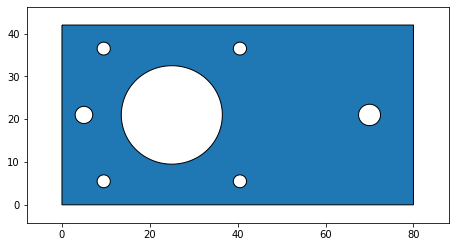

In [60]:
%matplotlib inline

from descartes import PolygonPatch

import matplotlib.pyplot as plt

cm = 2. / 2.54

fig, ax = plt.subplots( figsize=( shapes[ 0 ].bounds[ 2 ] * 0.12 * cm, shapes[ 0 ].bounds[ 3 ] * 0.12 * cm ))
patch = PolygonPatch( shapes[ 0 ].buffer( 0 ))
ax.add_patch( patch )
ax.set_xlim( -shapes[ 0 ].bounds[ 2 ] * 0.1, shapes[ 0 ].bounds[ 2 ] * 1.1 )
ax.set_ylim( -shapes[ 0 ].bounds[ 3 ] * 0.1, shapes[ 0 ].bounds[ 3 ] * 1.1 )
plt.show()


In [ ]:
%matplotlib inline

from descartes import PolygonPatch

import matplotlib.pyplot as plt

cm = 2. / 2.54

fig, ax = plt.subplots( figsize=( shapes[ 0 ].bounds[ 2 ] * 0.12 * cm, shapes[ 0 ].bounds[ 3 ] * 0.12 * cm ))
patch = PolygonPatch( shapes[ 0 ].buffer( 1 ))
ax.add_patch( patch )
ax.set_xlim( -shapes[ 0 ].bounds[ 2 ] * 0.1, shapes[ 0 ].bounds[ 2 ] * 1.1 )
ax.set_ylim( -shapes[ 0 ].bounds[ 3 ] * 0.1, shapes[ 0 ].bounds[ 3 ] * 1.1 )
plt.show()